In [19]:
import librosa
import numpy as np

sample_rate = 22050
def extract_features(file_path):
    audio, sample = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sample_rate).T, axis=0)
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=audio, sr=sample_rate).T, axis=0)

    combined_features = np.hstack([mfccs, chroma, spectral_contrast])

    return combined_features

In [20]:
import os
import pandas as pd

data = {}
paras = []
labels = []
base_path = "data/voices"

for label in os.listdir(base_path):
    folder_path = os.path.join(base_path, label)
    for f in os.listdir(folder_path):
        file_path = os.path.join(folder_path, f)
        try:
            features = extract_features(file_path)
            paras.append(features)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

data.update({'para': paras})
data.update({'label': labels})

df = pd.DataFrame(data)
print(df)
df.to_csv("emotion_dataset.csv", index=False)


                                                  para    label
0    [-625.6010131835938, 65.5589828491211, 3.51763...  neutral
1    [-598.2384643554688, 62.16184616088867, -1.875...  neutral
2    [-646.5132446289062, 60.74503707885742, -16.38...  neutral
3    [-646.4668579101562, 46.71648406982422, -8.977...  neutral
4    [-693.6901245117188, 61.060157775878906, -2.84...  neutral
..                                                 ...      ...
114  [-562.0607299804688, 57.9602165222168, -14.572...      sad
115  [-694.5256958007812, 70.3426742553711, -8.5212...      sad
116  [-700.8250732421875, 71.64476013183594, -4.714...      sad
117  [-605.9327392578125, 58.818199157714844, -9.65...      sad
118  [-542.0526123046875, 53.769371032714844, -13.0...      sad

[119 rows x 2 columns]


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

df = pd.read_csv("emotion_dataset.csv")

df_temp = []
for i in df['para']:
    frame = [ float(num) for num in (i.strip('[]').split())]
    df_temp.append(frame)
df['para'] = df_temp

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

x = np.vstack(df['para']) #features
y = df['label'].values #labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

smote = SMOTE(sampling_strategy='auto', k_neighbors=1) #Reduce over-sampling dataset
x_res, y_res = smote.fit_resample(x_train, y_train)


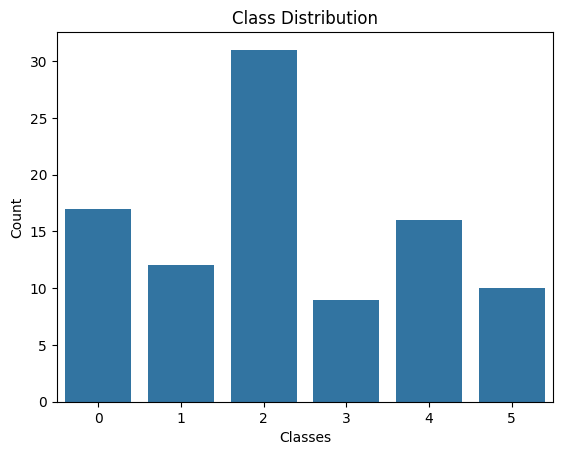

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_train)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

Model knn_emotion_recognition.pkl not found.
Accuracy:  62.50%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.50      0.67      0.57         3
           2       1.00      0.57      0.73         7
           3       0.50      1.00      0.67         2
           4       0.50      0.67      0.57         3
           5       0.40      0.67      0.50         3

    accuracy                           0.62        24
   macro avg       0.65      0.68      0.62        24
weighted avg       0.76      0.62      0.64        24



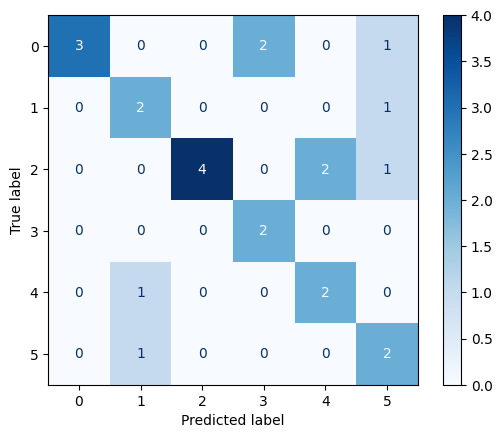

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import joblib

file_name = "knn_emotion_recognition.pkl"
if os.path.isfile(file_name):
    knn_model = joblib.load(file_name)
    print(f"Model loaded from {file_name}")
else:
    knn_model = KNeighborsClassifier(n_neighbors=3, leaf_size=2, algorithm='ball_tree', metric='manhattan', weights='distance')
    print(f"Model {file_name} not found.")

knn_model.fit(x_res, y_res)

y_pred = knn_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100: .2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'leaf_size': [2, 5, 10, 15, 20, 25, 30, 35, 40, 50],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring='accuracy')
grid_search.fit(x_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_knn_model = grid_search.best_estimator_

/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 2, 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


In [ ]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Assuming x and y are your data features and labels
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1

# Create a mesh grid
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, 0.1),  # Increase step size to reduce memory usage
    np.arange(y_min, y_max, 0.1)
)

# Create the grid points for prediction (59 features: first 2 from grid, others as mean)
grid_points = np.c_[xx.ravel(), yy.ravel()]  # (N, 2)
default_features = np.mean(x, axis=0)[2:]  # Mean values for remaining 57 features
grid_points_full = np.hstack([grid_points, np.tile(default_features, (grid_points.shape[0], 1))])

# Predict the class for each point in the grid
Z = knn_model.predict(grid_points_full)
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolor='k', cmap=plt.cm.Paired)
plt.title('k-NN Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [142]:
import joblib

joblib.dump(best_knn_model, "knn_emotion_recognition.pkl")

['knn_emotion_recognition.pkl']

In [ ]:
loaded_model = joblib.load("knn_emotion_recognition.pkl")

In [ ]:
file_path = ""
features = extract_features(file_path).reshape(1, -1)

predicted_label = loaded_model.predict(features)
emotion = label_encoder.inverse_transform(predicted_label)
print(f"Predicted Result: {emotion}")